In [1]:
# Display
from IPython.display import Image, display
import matplotlib.cm as cm
import numpy as np
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import DATALOADER
import sklearn.model_selection

In [8]:
path = 'Data_paths.csv'
df = pd.read_csv(path)
df = df[df.moa != 'DMSO']
model_path = 'train_results/KFOLDRN1012022.06.17_17.06.26/KFOLDRN1012022.06.17_17.06.26_checkpoint'
model = keras.models.load_model(model_path)

In [9]:
model.layers[-1].activation = None
moa_one_hot_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
moa_one_hot_encoder.fit(df['moa'].to_numpy().reshape(-1, 1))
dataloader = DATALOADER.DataLoader(df, one_hot_encoder=moa_one_hot_encoder, batch_size=1, shuffle = False)


In [10]:
def get_grad_cam(img_array):
    inp = model.get_layer('resnet101v2').inputs
    out = model.get_layer('resnet101v2').outputs
    
    final_conv_model = keras.Model(inp, out)
    clf_input = keras.Input(shape = final_conv_model.output.shape[1:])
    clf_input = model.get_layer('flatten')(clf_input)
    clf_model = keras.Model(clf_input, model.get_layer('dense')(clf_input))
    
    with tf.GradientTape() as tape:
        final_conv_output = final_conv_model(img_array)
        tape.watch(final_conv_output)
        
        prediction = clf_model(model.get_layer('flatten')(final_conv_output))
        predicted_class = tf.argmax(prediction[0])
        prediction_class_value = prediction[0, predicted_class]
        
    gradient = tape.gradient(prediction_class_value, final_conv_output)

    gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))
    final_conv_output = final_conv_output.numpy()[0]
    gradient_channels = gradient_channels.numpy()

    for i in range(gradient_channels.shape[-1]):
        final_conv_output[:, :, i] *= gradient_channels[i]

    heatmap = np.mean(final_conv_output, axis=-1)

    heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

    heatmap = np.uint8(255 * heatmap_normalized )
    color_map = plt.cm.get_cmap('jet')

    color_map = color_map(np.arange(256))[:, :3]
    heatmap = color_map[heatmap]
    heatmap = keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((68, 68))
    heatmap = np.asarray(heatmap, dtype = np.float32)
    final_img = heatmap * 0.4 + img_array[0]
    final_img = keras.preprocessing.image.array_to_img(final_img)
    return final_img, heatmap_normalized



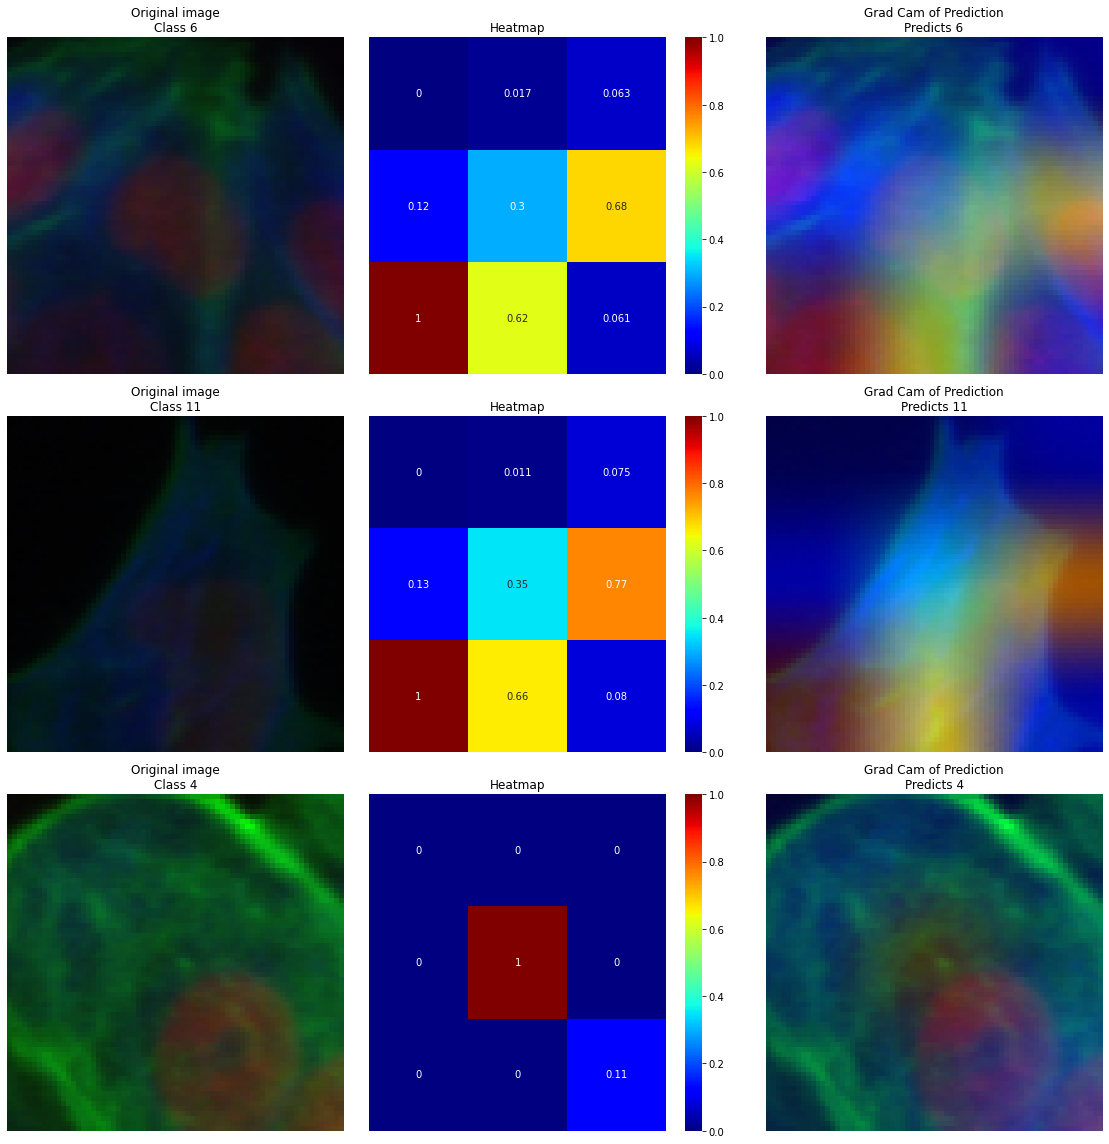

In [11]:
fig, axs = plt.subplots(3,3, figsize = (16,16))
random_indices = df.groupby('moa').sample(n=1, random_state = 0).sample(n=3, random_state = 0).index.to_list()

for index, random_index in enumerate(random_indices):
    
    img_array = np.load(df.iloc[random_index].path)
    img_array = img_array.reshape(-1, 68, 68, 3)
    
    img, moa = dataloader.__getitem__(random_index)
    pred = model.predict(img)
    grad_cam, heatmap = get_grad_cam(img_array)
    
    axs[index][0].set_title(f"Original image\nClass {np.argmax(moa)}")
    axs[index][1].set_title('Heatmap')
    axs[index][2].set_title(f"Grad Cam of Prediction\nPredicts {np.argmax(pred)}")
    
    axs[index][0].imshow(img_array.reshape(68,68,3))
    sns.heatmap(heatmap, annot = True, ax = axs[index][1], cmap = 'jet')
    #.()
    axs[index][2].imshow(grad_cam)
    
    axs[index][0].axis('off')
    axs[index][1].axis('off')
    axs[index][2].axis('off')
fig.tight_layout()